In [1]:
import sys
import scipy
import numpy as np
import qptransform as qp
import matplotlib.pyplot as plt

from multiprocessing import Pool
from inject_waveforms import get_timeseries
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q

/Users/ravioli/miniconda3/envs/idk/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
def downsample(data):
    times = np.linspace(0, data.duration, len(data.data))
    downsampling=int(np.ceil(np.ceil(1./(times[1]-times[0]))/2048.))
    data_downsampled=scipy.signal.decimate(data.data, downsampling) # downsample data
    times = np.linspace(0, data.duration, len(data_downsampled)+1)
    data_downsampled = qp.TimeSeries(data_downsampled, x0=times[0], dx=times[1]-times[0], copy=False)
    data_downsampled.whiten()
    return data_downsampled

In [9]:
q = np.logspace(-0.5, 0, 20)
mchirp = np.linspace(10, 30, 20)

r1 = np.random.randint(0, 20)
r2 = np.random.randint(0, 20)

m1 = mass1_from_mchirp_q(mchirp[r1], q[r2])
m2 = mass2_from_mchirp_q(mchirp[r1], q[r2])

print(f"m1: {m1:.3f}, m2: {m2:.3f}\n q: {q[r2]:.3f}, mchirp: {mchirp[r1]:.3f}")

m1: 12.347, m2: 25.548
 q: 0.483, mchirp: 15.263


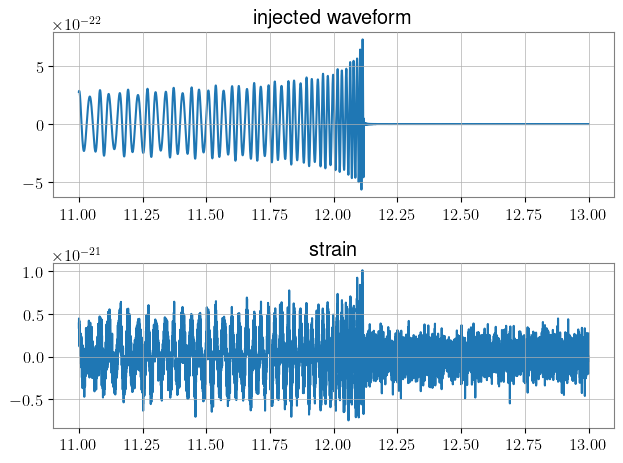

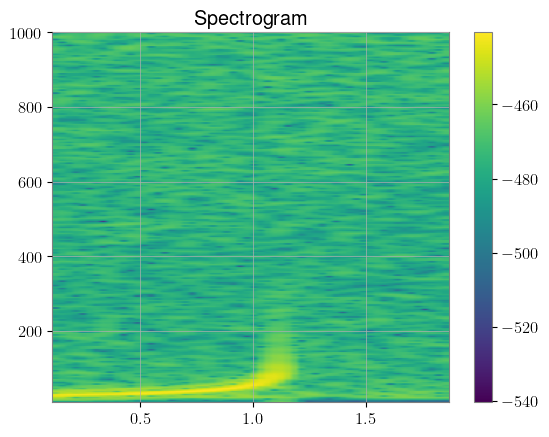

In [10]:
strain, hp, inj, inj1 = get_timeseries(
        m1=m1,
        m2=m2,
        snr=100,
        eccentricity=0.1,
        f_low=20,
    )

n = int(inj.sample_times[np.argmax(np.abs(inj.data))])+1
trange = (n - 2, inj.duration - n)
inj = inj.crop(*trange)
trange = (n - 2 - strain.start_time, strain.end_time - n)
strain = strain.crop(*trange)

plt.subplot(211)
plt.plot(inj.sample_times, inj)
plt.title('injected waveform')
plt.subplot(212, sharex=plt.gca())
plt.plot(strain.sample_times, strain)
plt.title('strain')
plt.tight_layout()
plt.show()

#create spectrogram of the strain using fourier transform
NFFT = 1024  # Length of the windowing segments
Fs = 4096  # The sampling frequency
fig, ax = plt.subplots(1, 1)
Pxx, freqs, bins, im = ax.specgram(strain, NFFT=NFFT, Fs=Fs, noverlap=900)
ax.set_ylim([10, 1000])
fig.colorbar(im, ax=ax)
ax.set_title('Spectrogram')
plt.show()

In [11]:
data_downsampled = downsample(strain)

In [12]:
frange=[20., 200.]
alpha=0.05
alpha_find_Qp=0.2
qrange=[2.*np.pi, 6.*np.pi]
filmethod='highpass_threshold_filtering'
denoising_threshold=7.
energy_density_threshold=7.

QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod)
print(f'Q={round(QPINSTANCE.Q, 8)}\np={round(QPINSTANCE.p,8)}\npeak={QPINSTANCE.peak}\nenergy density={round(QPINSTANCE.energy_density,2)}\narea={round(QPINSTANCE.TF_area,2)}')

/Users/ravioli/Documents/ligo/qp-transform/qptransform.py:531: UserWarning: 'energy_density' does not converge for finding (Q,p), 'energy_peak' is used instead
  warnings.warn("'energy_density' does not converge for finding (Q,p), 'energy_peak' is used instead")


Q=27.90133337
p=0.05183186
peak={'energy': 1.304869936120293e-41, 'time': 0.9216499328613281, 'frequency': 46.432890531933595}
energy density=0.0
area=0.0


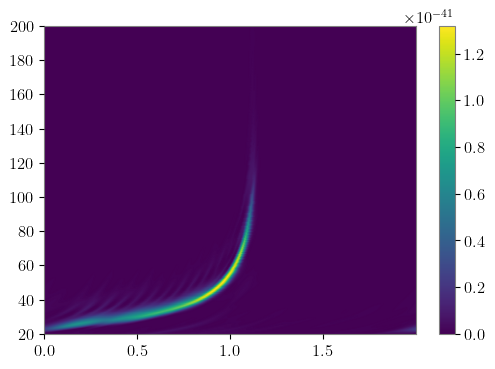

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
vmax=QPINSTANCE.qpspecgram.max()
ax.pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax.colorbar = plt.colorbar(ax.get_children()[0], ax=ax, orientation='vertical')
ax.grid(False)

# **Multiprocessing**

In [ ]:
def run_injections(theta):
    # Unpack the parameters
    mchirp, q = theta

    # Get the masses
    m1, m2 = mass1_from_mchirp_q(mchirp, q), mass2_from_mchirp_q(mchirp, q)

    # Get the time series
    strain, _, inj, _ = get_timeseries(
        m1=m1,
        m2=m2,
        snr=100,
        eccentricity=0.1,
        f_low=20,
    )
    n = int(inj.sample_times[np.argmax(np.abs(inj.data))])+1
    trange = (n - 2 - strain.start_time, strain.end_time - n)
    strain = strain.crop(*trange)
    data_downsampled = downsample(strain)

    # Get the Qp-transform
    frange=[20., 200.]
    alpha=0.05
    alpha_find_Qp=0.2
    filmethod='highpass_threshold_filtering'
    denoising_threshold=7.
    QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod)
    BESTQ = QPINSTANCE.Q
    BESTP = QPINSTANCE.p
    with open('results.csv', 'a') as f:
        for p in np.linspace(0, 0.3, 30):
            qpinstance=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, prange=[p,p], qrange=[BESTQ,BESTQ])
            f.write(f'{q},{mchirp},{qpinstance.Q},{p},{BESTQ},{BESTP}\n')
        for Q in np.linspace(20, 40, 30):
            qpinstance=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=[Q,Q], prange=[BESTP,BESTP])
            f.write(f'{q},{mchirp},{Q},{qpinstance.p},{BESTQ},{BESTP}\n')

In [23]:
#meshgrid of mchirp and q
grid = np.meshgrid(mchirp, q)
theta = np.array([m.flatten() for m in grid]).T

pool = Pool(4)
for i, _ in enumerate(pool.imap_unordered(run_injections, theta), 1):
    sys.stderr.write('\rdone {0:%}'.format(i/400))

done 100.000000%